# Importing dependencies

The following code block contains all import statements for all required dependencies. 

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import re
import time
from lime.lime_text import LimeTextExplainer
from sklearn.model_selection import train_test_split

# Text Preprocessing for Transformer Models

The following codeblock contains a lightweight preprocessing function that handles basic text issues (encoding, whitespace) while preserving semantic content critical for transformer-based models. 

Unlike traditional NLP preprocessing that heavily modifies text (through stemming, lemmatisation, stopword removal, etc.), this approach is deliberately minimalistic to retain stylistic elements and contextual information that transformer models can leverage for better classification performance. The reasons for this design choice are:
1. Transformer models (e.g. MobileBERT) are pre-trained on raw, unprocessed text with all variations intact, meaning it has already learned relationships between word forms (e.g. 'run' vs. running').
2. Word forms, tenses, writing style, etc. can be important context clues in fake news detection and stemming may remove these contextual details.



In [4]:
# v2.5 step2

# function to perform minimal text preprocessing for transformer models
# arguments:
# text - input text to preprocess (string)
# max_length - maximum number of words to keep (default: 512)
#
# returns preprocessed text string
def preprocess_text(text, max_length=512):
    # step 1: handle edge cases
    if not isinstance(text, str):
        return ""
    
    # step 2: clean encoding issues
    # remove non-ascii characters that could cause problems
    text = text.encode('ascii', 'ignore').decode('ascii')
    
    # step 3: normalize text format
    # replace multiple whitespace characters with single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    # step 4: truncate oversized inputs
    # transformer models have context length limits
    words = text.split()
    if len(words) > max_length:
        text = ' '.join(words[:max_length])
        
    return text

# LIAR and ISOT Dataset Processing Modules

The following codeblock handles the loading and preprocessing of the LIAR dataset, which contains political statements with varying degrees of truthfulness:

1. Column Definition - Sets up the structure for the TSV data, including fields for statement, speaker, context, and truthfulness metrics.
2. Data Loading - Reads the train, validation, and test sets with appropriate column mapping.
3. Label Binarization - Converts the 6-point truthfulness scale into a binary classification task:
    - 'pants-fire', 'false', and 'barely-true' → fake (0)
    - 'half-true', 'mostly-true', and 'true' → real (1)
4. Source Tracking - Tags all entries as originating from the 'liar' dataset to enable source-specific evaluation later.

This preprocessing maintains the rich metadata available in LIAR while standardizing the label format for binary classification.

It will also manage the loading and preprocessing of the ISOT dataset, which contains full news articles labeled as real or fake:

1. Data Acquisition - Loads separately stored fake and real news articles from CSV files.
2. Binary Labeling - Assigns clear binary labels (0 for fake, 1 for real) to each article.
3. Source Identification - Tags all entries as originating from the 'isot' dataset for later analysis.
4. Text Consolidation - Combines article titles with full text to create a comprehensive 'statement' field that parallels the LIAR dataset structure.
5. Data Preparation - Performs concatenation, shuffling, and train/validation/test splitting with configurable proportions.

This preprocessing creates standardized data splits that maintain the same structure as the LIAR dataset, enabling unified handling in downstream tasks.

In [6]:
# module for loading and preprocessing LIAR dataset
# arguments:
# train_path, valid_path, test_path - paths to LIAR dataset files
# return - tuple of (train_df, valid_df, test_df) with preprocessed data
def load_liar_dataset(train_path, valid_path, test_path):
    # step 1: define column names for LIAR dataset
    column_names = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 
                   'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 
                   'mostly_true_counts', 'pants_on_fire_counts', 'context']
    
    # step 2: load datasets
    train_df = pd.read_csv(train_path, sep='\t', names=column_names)
    valid_df = pd.read_csv(valid_path, sep='\t', names=column_names)
    test_df = pd.read_csv(test_path, sep='\t', names=column_names)
    
    # step 3: convert labels to binary (0 for fake, 1 for real)
    # map 'pants-fire', 'false', 'barely-true' to fake (0)
    # map 'half-true', 'mostly-true', 'true' to real (1)
    label_map = {
        'pants-fire': 0, 'false': 0, 'barely-true': 0,
        'half-true': 1, 'mostly-true': 1, 'true': 1
    }
    
    # apply mapping to each dataset
    train_df['label'] = train_df['label'].map(label_map)
    valid_df['label'] = valid_df['label'].map(label_map)
    test_df['label'] = test_df['label'].map(label_map)
    
    # step 4: add source identifier
    train_df['source'] = 'liar'
    valid_df['source'] = 'liar'
    test_df['source'] = 'liar'
    
    return train_df, valid_df, test_df

# module for loading and preprocessing ISOT dataset
# arguments:
# fake_path - path to Fake.csv
# real_path - path to Real.csv
# test_split - fraction of data to use for testing (default: 0.2)
# valid_split - fraction of data to use for validation (default: 0.1)
# return - tuple of (train_df, valid_df, test_df) with preprocessed data
def load_isot_dataset(fake_path, real_path, test_split=0.2, valid_split=0.1):
    # step 1: load fake and real news
    fake_df = pd.read_csv(fake_path)
    real_df = pd.read_csv(real_path)
    
    # step 2: add binary labels (0 for fake, 1 for real)
    fake_df['label'] = 0
    real_df['label'] = 1
    
    # step 3: add source identifier
    fake_df['source'] = 'isot'
    real_df['source'] = 'isot'
    
    # step 4: combine text and title for ISOT dataset
    fake_df['statement'] = fake_df['title'] + " " + fake_df['text'] 
    real_df['statement'] = real_df['title'] + " " + real_df['text']
    
    # step 5: combine datasets
    combined_df = pd.concat([fake_df, real_df], ignore_index=True)
    
    # step 6: shuffle data
    combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # step 7: split into train, validation, and test sets
    test_size = int(len(combined_df) * test_split)
    valid_size = int(len(combined_df) * valid_split)
    
    test_df = combined_df[:test_size]
    valid_df = combined_df[test_size:test_size+valid_size]
    train_df = combined_df[test_size+valid_size:]
    
    return train_df, valid_df, test_df

def load_welfake_dataset(welfake_path):
    # Step 1: load the raw dataset
    welfake_df = pd.read_csv(welfake_path)

    # Step 2: rename/reshape columns
    welfake_df['statement'] = welfake_df['title'] + " " + welfake_df['text'].fillna("")
    welfake_df['label'] = welfake_df['label']  # Already binary (1=real, 0=fake)
    welfake_df['source'] = "welfake"
    welfake_df = welfake_df[['statement','label','source']]

    # Step 3: do train/valid/test split
    welfake_train, welfake_temp = train_test_split(welfake_df, test_size=0.2, random_state=42)
    welfake_valid, welfake_test = train_test_split(welfake_temp, test_size=0.5, random_state=42)
    
    # Step 4: print dataset statistics
    print(f"WELFake dataset:")
    print(f"  Total: {len(welfake_df)} samples")
    print(f"  Train: {len(welfake_train)} samples")
    print(f"  Valid: {len(welfake_valid)} samples")
    print(f"  Test: {len(welfake_test)} samples")

    return welfake_train, welfake_valid, welfake_test

# Dataset Combination Module

The following codeblock handles the integration of both LIAR and ISOT datasets into a unified training pipeline:

1. Dataset Loading - Calls the specialized loading functions for both LIAR and ISOT datasets to obtain preprocessed dataframes.
2. Data Integration - Concatenates the corresponding splits (train/validation/test) from each dataset while preserving source identification.
3. Training Randomization - Shuffles the training data to ensure model convergence isn't affected by dataset order or source grouping.
4. Statistics Reporting - Provides detailed counts of samples from each source within each split, offering transparency about dataset composition.

This unified approach enables the model to learn from both political statements (LIAR) and full news articles (ISOT) simultaneously, potentially improving generalization across different types of misinformation.

In [8]:
# function to load, preprocess and combine both datasets
# arguments:
# liar_paths - tuple of (train_path, valid_path, test_path) for LIAR dataset
# isot_paths - tuple of (fake_path, real_path) for ISOT dataset
# return - tuple of (train_df, valid_df, test_df) with combined data
def combine_datasets(liar_paths, isot_paths, welfake_path=None):
    # step 1: load datasets
    liar_train, liar_valid, liar_test = load_liar_dataset(*liar_paths)
    isot_train, isot_valid, isot_test = load_isot_dataset(*isot_paths)
    
    # step 1.5: load WELFake dataset if path provided
    if welfake_path:
        welfake_train, welfake_valid, welfake_test = load_welfake_dataset(welfake_path)
        # step 2: combine datasets including WELFake
        train_df = pd.concat([liar_train, isot_train, welfake_train], ignore_index=True)
        valid_df = pd.concat([liar_valid, isot_valid, welfake_valid], ignore_index=True)
        test_df = pd.concat([liar_test, isot_test, welfake_test], ignore_index=True)
    else:
        # step 2: combine datasets without WELFake
        train_df = pd.concat([liar_train, isot_train], ignore_index=True)
        valid_df = pd.concat([liar_valid, isot_valid], ignore_index=True)
        test_df = pd.concat([liar_test, isot_test], ignore_index=True)
    
    # step 3: shuffle training data
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # step 4: print dataset statistics
    print("Dataset statistics:")
    print(f"  Train set: {len(train_df)} samples")
    print(f"    LIAR: {len(liar_train)} samples")
    print(f"    ISOT: {len(isot_train)} samples")
    print(f"    WELFake: {len(welfake_train)} samples")
    print(f"  Validation set: {len(valid_df)} samples")
    print(f"    LIAR: {len(liar_valid)} samples")
    print(f"    ISOT: {len(isot_valid)} samples")
    print(f"    WELFake: {len(welfake_valid)} samples")
    print(f"  Test set: {len(test_df)} samples")
    print(f"    LIAR: {len(liar_test)} samples")
    print(f"    ISOT: {len(isot_test)} samples")
    print(f"    WELFake: {len(welfake_test)} samples")
    
    return train_df, valid_df, test_df

# Custom Dataset with Source Tracking Capability

The following codeblock implements a PyTorch Dataset class specifically designed for fake news classification with multiple data sources:

1. Source-Aware Construction - Stores not only text and labels but also tracks the origin dataset ('liar' or 'isot') of each sample for later evaluation.
2. BERT-Compatible Tokenization - Handles text encoding with transformers tokenizer, managing padding, truncation, and tensor conversion automatically.
3. PyTorch Integration - Implements standard Dataset methods (len, getitem) for seamless integration with PyTorch DataLoader.
4. Source Retrieval - Provides a dedicated method (get_sources) to extract source information during evaluation, enabling dataset-specific performance analysis.

This custom dataset enables the pipeline to maintain dataset provenance throughout training and evaluation, allowing for detailed performance analysis on each source individually - crucial for identifying where the model excels or struggles.

In [10]:
# dataset class that supports source tracking for dataset-aware evaluation
class FakeNewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        # step 1: store dataframe and extract necessary columns
        self.df = df
        self.texts = df['statement'].tolist()
        self.labels = df['label'].tolist()
        self.sources = df['source'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # step 1: get text and label for the index
        text = self.texts[idx]
        label = self.labels[idx]
        
        # step 2: tokenize the text
        encodings = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # step 3: return the encodings and label
        return {
            'input_ids': encodings['input_ids'].squeeze(),
            'attention_mask': encodings['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
    
    # Method to get sources for dataset-aware evaluation
    def get_sources(self):
        return self.sources

# Dataset Balancing: Weighted Sampler

The following codeblock implements a weighted sampling strategy to ensure balanced representation of multiple data sources:

1. Source Frequency Analysis - Calculates the number of samples from each source (LIAR and ISOT) in the training data.
2. Inverse Frequency Weighting - Assigns weights to samples inversely proportional to their source's frequency, giving higher weight to samples from underrepresented sources.
3. Balanced Sampling Implementation - Creates a PyTorch WeightedRandomSampler that uses these weights to sample with equal probability from each source dataset.
4. Representative Training - Ensures that during each training epoch, the model sees approximately equal numbers of samples from each source, preventing bias toward the larger dataset.

This balanced sampling approach is crucial for preventing the model from simply optimizing for the larger dataset (ISOT) while neglecting performance on the more challenging dataset (LIAR), leading to better generalization across diverse fake news contexts.

In [12]:
# weighted sampler to balance dataset influence during training
# arguments:
# train_df - training dataframe with 'source' column
# return - PyTorch sampler that balances dataset representation
def create_balanced_sampler(train_df):
    # step 1: calculate weights for each sample based on source
    dataset_counts = train_df['source'].value_counts()
    total_samples = len(train_df)
    num_datasets = len(dataset_counts)  # Dynamic count of datasets
    
    # calculate weights (inverse of dataset frequency)
    weights = []
    for source in train_df['source']:
        source_count = dataset_counts[source]
        weight = total_samples / (num_datasets * source_count)
        weights.append(weight)
    
    # step 2: create weighted sampler
    weights = torch.FloatTensor(weights)
    sampler = torch.utils.data.WeightedRandomSampler(
        weights=weights,
        num_samples=len(weights),
        replacement=True
    )
    
    return sampler

# Dataset Balancing: Class Weights

The following codeblock implements a class weighting mechanism to address label imbalance during model training:

1. Class Distribution Analysis - Counts the frequency of each label (fake vs. real) in the training dataset.
2. Inverse Frequency Weighting - Calculates weights inversely proportional to class frequency, giving higher importance to underrepresented classes.
3. Class Weight Normalization - Normalizes weights by the number of classes and total samples to maintain balanced training signals.
4. Loss Function Integration - Returns class weights as a PyTorch tensor ready for integration with weighted loss functions.

This class weighting approach addresses a different dimension of balance than the previous sampler - while the sampler balanced between data sources (LIAR vs. ISOT), this function balances between class labels (fake vs. real) within the combined dataset. Together, these mechanisms ensure the model learns effectively despite imbalances in both dataset size and class distribution.

In [14]:
# calculate class weights for loss function to handle class imbalance
# arguments:
# train_df - training dataframe with 'label' column
# return - class weights tensor for balanced loss calculation
def calculate_class_weights(train_df):
    # step 1: count classes
    class_counts = train_df['label'].value_counts().to_dict()
    total_samples = len(train_df)
    
    # step 2: calculate weights (inverse of class frequency)
    num_classes = len(class_counts)
    weights = []
    
    for class_idx in range(num_classes):
        if class_idx in class_counts:
            weight = total_samples / (num_classes * class_counts[class_idx])
        else:
            weight = 1.0
        weights.append(weight)
    
    # step 3: convert to tensor
    class_weights = torch.FloatTensor(weights)
    return class_weights

# Evaluation Metrics Computation

The following codeblock implements a multi-metric evaluation function for assessing fake news classification performance:

1. Prediction Processing - Converts raw model outputs (logits) into class predictions by identifying the highest probability class.
2. Accuracy Calculation - Measures the overall percentage of correctly classified samples, providing a general performance indicator.
3. Precision and Recall Assessment - Evaluates the model's ability to avoid false positives (precision) and catch all instances of fake news (recall).
4. F1 Score Computation - Calculates the harmonic mean of precision and recall, offering a balanced metric for classification performance.
5. ROC-AUC Evaluation - Assesses the model's ability to distinguish between classes across different classification thresholds, with a safeguard for single-class edge cases.

This comprehensive evaluation approach provides multiple perspectives on model performance, allowing for nuanced assessment beyond simple accuracy. These metrics are particularly important in fake news detection where the costs of false positives and false negatives may differ significantly.

In [16]:
# compute metrics for model evaluation
# arguments:
# eval_pred - tuple of (predictions, labels)
# return - dictionary with evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, zero_division=0),
        'recall': recall_score(labels, predictions),
        'f1': f1_score(labels, predictions),
        'roc_auc': roc_auc_score(labels, predictions) if len(np.unique(labels)) > 1 else 0
    }

# Hyperparameter Tuning with Bayesian optimisation

The following codeblock implements an advanced hyperparameter tuning approach using Bayesian optimization through Optuna:

1. Parameter Space Exploration - Rather than testing each parameter individually, this approach models the entire parameter space and strategically samples promising combinations based on previous results.
2. Efficient Trial Scheduling - Uses Tree-structured Parzen Estimator (TPE) to intelligently focus computational resources on the most promising parameter regions.
3. Trial Persistence - Implements a robust checkpointing mechanism that:
    - Saves model state after each trial
    - Can resume interrupted trials exactly where they left off
    - Maintains a database of all trial results for analysis
4. Automatic Pruning - Implements early termination of unpromising trials using MedianPruner to save computational resources.
5. Comprehensive Analysis - Provides detailed insights including:
    - Parameter importance analysis
    - Ranking of top-performing configurations
    - Performance visualization across the parameter space
   
This Bayesian approach is significantly more efficient than the previously-implemented grid search, identifying better hyperparameter combinations with fewer trials by learning from previous results. The checkpointing system also ensures resilience against interruptions, making the tuning process more practical for resource-intensive transformer models.

In [18]:
# function to perform hyperparameter tuning using Bayesian optimization
# arguments:
# model_name - pretrained model name to use
# train_dataset - dataset for model training
# valid_dataset - dataset for validation during tuning
# train_sampler - sampler for balanced data selection (optional)
# n_trials - number of hyperparameter combinations to try (default: 20)
#
# returns dictionary with best hyperparameter combination
def tune_hyperparameters(model_name, train_dataset, valid_dataset, train_sampler, n_trials=20):
    # step 1: prepare storage directory
    base_dir = "./hp_tuning_optuna"
    os.makedirs(base_dir, exist_ok=True)
    
    # step 2: define objective function for optimization
    def objective(trial):
        # step 2.1: sample hyperparameter values
        lr = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
        weight_decay = trial.suggest_float("weight_decay", 0.01, 0.2, log=True)
        batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
        epochs = trial.suggest_int("epochs", 2, 3)
        gradient_accumulation_steps = trial.suggest_categorical("gradient_accumulation_steps", [1, 2, 4]) # new (v2.5 step2)
        
        # step 2.2: create directory for this trial's outputs
        trial_dir = f"{base_dir}/trial_{trial.number}"
        os.makedirs(trial_dir, exist_ok=True)
        
        # step 2.3: check for existing checkpoint
        checkpoint_path = f"{trial_dir}/checkpoint.pt"
        start_epoch = 0  # default starting point
        
        # step 2.4: configure training parameters
        training_args = TrainingArguments(
            output_dir=trial_dir,
            eval_strategy="epoch",
            save_strategy="epoch",
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=epochs,
            weight_decay=weight_decay,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            push_to_hub=False,
            report_to="none",
            logging_steps=500,
            disable_tqdm=False,
            save_total_limit=1,  # keep only best checkpoint
            gradient_accumulation_steps=gradient_accumulation_steps # new (v2.5 step2): gradient accumulation
        )
        
        # step 2.5: initialize model and trainer
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=2
        )
        
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=valid_dataset,
            compute_metrics=compute_metrics
        )
        
        # step 2.6: apply balanced sampling if provided
        original_get_train_dataloader = None
        if train_sampler is not None:
            # create balanced dataloader
            train_dataloader = DataLoader(
                train_dataset,
                batch_size=batch_size,
                sampler=train_sampler
            )
            # store original method for later restoration
            original_get_train_dataloader = trainer.get_train_dataloader
            # override with our balanced dataloader
            trainer.get_train_dataloader = lambda: train_dataloader
        
        # step 2.7: attempt to resume from checkpoint if available
        if os.path.exists(checkpoint_path):
            print(f"Resuming from checkpoint for trial {trial.number}")
            checkpoint_state = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint_state['model_state_dict'])
            start_epoch = checkpoint_state['epoch']
            
            # if already completed, just return saved result
            if start_epoch >= epochs:
                return checkpoint_state['f1_score']
        
        # step 2.8: train model if not already completed
        if start_epoch < epochs:
            try:
                # perform training
                trainer.train()
                
                # compute performance metrics
                eval_result = trainer.evaluate()
                f1_score = eval_result["eval_f1"]
                
                # save checkpoint for possible resumption
                torch.save({
                    'epoch': epochs,
                    'model_state_dict': model.state_dict(),
                    'f1_score': f1_score
                }, checkpoint_path)
                
                # report result to Optuna
                trial.report(f1_score, epochs - 1)
                
                # restore original dataloader if modified
                if original_get_train_dataloader is not None:
                    trainer.get_train_dataloader = original_get_train_dataloader
                
                print(f"  Trial {trial.number} - F1 Score: {f1_score:.4f}")
                return f1_score
                
            except Exception as e:
                # handle training failures by saving state
                if start_epoch > 0:
                    torch.save({
                        'epoch': start_epoch,
                        'model_state_dict': model.state_dict(),
                        'f1_score': 0  # default for failed runs
                    }, checkpoint_path)
                print(f"Training failed: {e}")
                return 0
    
    # step 3: create and configure the Optuna study
    study = optuna.create_study(
        direction="maximize",  # maximize F1 score
        sampler=TPESampler(seed=42),  # use Tree-structured Parzen Estimator
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=5),  # prune unpromising trials
        study_name="fake_news_detection",
        storage=f"sqlite:///{base_dir}/optuna_study.db",  # persistent storage
        load_if_exists=True  # resume existing study if available
    )
    
    # step 4: run optimization process
    study.optimize(objective, n_trials=n_trials)
    
    # step 5: extract and display results
    best_params = study.best_params
    best_f1 = study.best_value
    
    # step 5.1: print summary information
    print("\nOptuna hyperparameter tuning complete!")
    print(f"Best F1 score: {best_f1:.4f}")
    print(f"Best parameters: {best_params}")
    
    # step 5.2: show parameter importance if possible
    try:
        importance = optuna.importance.get_param_importances(study)
        print("\nHyperparameter importance:")
        for param, score in importance.items():
            print(f"  {param}: {score:.4f}")
    except:
        print("Could not calculate hyperparameter importance (requires at least 2 completed trials)")
    
    # step 5.3: show top performing configurations
    print("\nTop 5 trials:")
    sorted_trials = sorted(study.trials, key=lambda t: t.value if t.value is not None else -1, reverse=True)
    for i, trial in enumerate(sorted_trials[:5]):
        if trial.value is not None:
            print(f"Rank {i+1}: F1={trial.value:.4f}, Params={trial.params}")
    
    return best_params

# Source-Aware Model Evaluation Framework

The following codeblock implements a comprehensive evaluation system that distinguishes performance across different data sources:

1. Holistic Assessment - Computes standard metrics (accuracy, precision, recall, F1, ROC-AUC) across the entire test set for baseline performance.
2. Dataset-Specific Analysis - Segments evaluation results by source (LIAR vs. ISOT), revealing how the model performs on different types of fake news content.
3. Statistical Visualization - Generates confusion matrices both for the overall dataset and for each source individually, providing visual insight into classification patterns.
4. Performance Reporting - Formats results into clear, tabular displays that highlight the model's strengths and weaknesses across datasets.
5. Error Distribution Analysis - Enables identification of which dataset contributes more significantly to model errors, guiding future improvement efforts.

This sophisticated evaluation approach goes beyond simple accuracy metrics to provide crucial insights into model behavior across diverse fake news contexts - revealing whether performance is consistent or if the model excels on certa

In [20]:
# function to evaluate model with dataset awareness
# arguments:
# trainer - Trainer instance
# test_dataset - dataset to evaluate on
# return - dictionary with evaluation metrics
def evaluate_dataset_aware(trainer, test_dataset):
    # step 1: get overall metrics using trainer
    test_results = trainer.evaluate(test_dataset)
    
    # step 2: get dataset-specific metrics
    # get predictions
    test_predictions = trainer.predict(test_dataset)
    predictions = np.argmax(test_predictions.predictions, axis=1)
    true_labels = test_predictions.label_ids
    sources = test_dataset.get_sources()
    
    # step 3: convert results to a more readable format
    readable_results = {}
    for key, value in test_results.items():
        # Extract the actual metric name from keys like 'eval_accuracy'
        if key.startswith('eval_'):
            metric_name = key[5:]  # Remove 'eval_' prefix
            readable_results[metric_name] = round(value, 4)  # Round to 4 decimal places
        else:
            readable_results[key] = value
    
    # step 4: calculate dataset-specific metrics
    dataset_metrics = {'overall': readable_results}
    
    for source in set(sources):
        # Get indices for this source
        source_indices = [i for i, s in enumerate(sources) if s == source]
        source_preds = [predictions[i] for i in source_indices]
        source_labels = [true_labels[i] for i in source_indices]
        
        # Calculate metrics for this source
        if len(source_indices) > 0 and len(set(source_labels)) > 1:
            source_metrics = {
                'accuracy': round(accuracy_score(source_labels, source_preds), 4),
                'precision': round(precision_score(source_labels, source_preds, zero_division=0), 4),
                'recall': round(recall_score(source_labels, source_preds), 4),
                'f1': round(f1_score(source_labels, source_preds), 4),
                'roc_auc': round(roc_auc_score(source_labels, source_preds), 4) if len(set(source_labels)) > 1 else 0
            }
            dataset_metrics[source] = source_metrics
    
    # step 5: display overall metrics table
    overall_metrics = pd.DataFrame({
        'Metric': list(readable_results.keys()),
        'Value': list(readable_results.values())
    })
    print("\nOverall Performance Metrics:")
    print(overall_metrics.set_index('Metric').transpose())
    
    # step 6: display source-specific metrics
    for source in dataset_metrics.keys():
        if source != 'overall':
            source_df = pd.DataFrame({
                'Metric': list(dataset_metrics[source].keys()),
                'Value': list(dataset_metrics[source].values())
            })
            print(f"\n{source.upper()} Dataset Performance Metrics:")
            print(source_df.set_index('Metric').transpose())
    
    # step 7: create overall confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"]).plot(cmap="Blues")
    plt.title("Overall Fake News Detection Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    # step 8: create source-specific confusion matrices
    for source in set(sources):
        source_indices = [i for i, s in enumerate(sources) if s == source]
        if len(source_indices) > 0:
            source_preds = [predictions[i] for i in source_indices]
            source_labels = [true_labels[i] for i in source_indices]
            
            cm = confusion_matrix(source_labels, source_preds)
            plt.figure(figsize=(8, 6))
            ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"]).plot(cmap="Blues")
            plt.title(f"{source.upper()} Dataset Fake News Detection Confusion Matrix")
            plt.tight_layout()
            plt.show()
    
    return dataset_metrics

# Unified Fake News Detection Pipeline

The following codeblock implements the complete end-to-end pipeline for fake news detection with dataset balancing.

In [22]:
# main function to run the pipeline with dataset balancing and hyperparameter tuning
def run_balanced_fake_news_pipeline():
    # step 1: define paths
    liar_paths = (
        "data/liar_dataset/train.tsv",  # LIAR train path
        "data/liar_dataset/valid.tsv",  # LIAR validation path
        "data/liar_dataset/test.tsv"    # LIAR test path
    )
    
    isot_paths = (
        "data/isot_dataset/Fake.csv",   # ISOT fake news path
        "data/isot_dataset/True.csv"    # ISOT real news path
    )

    welfake_path = "data/welfake_dataset/WELFake_Dataset.csv"
    
    # step 2: load and combine datasets
    train_df, valid_df, test_df = combine_datasets(liar_paths, isot_paths, welfake_path)

    def apply_preprocessing(df, text_column):
        print(f"Applying minimal preprocessing to {len(df)} texts...")
        df[text_column] = df[text_column].apply(preprocess_text)
        return df

    # apply preprocessing to dataframes
    train_df = apply_preprocessing(train_df, text_column='statement')
    valid_df = apply_preprocessing(valid_df, text_column='statement')
    test_df = apply_preprocessing(test_df, text_column='statement')
    
    # step 3: initialize tokenizer
    model_name = "google/mobilebert-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # step 4: create datasets
    train_dataset = FakeNewsDataset(train_df, tokenizer)
    valid_dataset = FakeNewsDataset(valid_df, tokenizer)
    test_dataset = FakeNewsDataset(test_df, tokenizer)
    
    # step 5: create balanced sampler for training
    print("\nCreating balanced dataset sampler...")
    balanced_sampler = create_balanced_sampler(train_df)
    
    # step 6: perform hyperparameter tuning with Optuna
    best_hparams = tune_hyperparameters(
        model_name, 
        train_dataset, 
        valid_dataset, 
        balanced_sampler,
        n_trials=2  # adjust this (trials)
    )
    
    # step 7: train final model with optimal hyperparameters
    print("\nTraining final model with optimal hyperparameters...")
    
    # configure training with optimal hyperparameters
    training_args = TrainingArguments(
        output_dir="./balanced_model",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=best_hparams["learning_rate"],
        per_device_train_batch_size=best_hparams["batch_size"],
        per_device_eval_batch_size=best_hparams["batch_size"],
        num_train_epochs=best_hparams["epochs"],
        weight_decay=best_hparams["weight_decay"],
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        push_to_hub=False,
        report_to="none",
        gradient_accumulation_steps=best_hparams.get("gradient_accumulation_steps", 1) #new (v2.5 step2): gradient accumulation
    )
    
    # initialize model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=2
    )
    
    # set up early stopping
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=2,
        early_stopping_threshold=0.001
    )
    
    # initialize Trainer for final training
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback]
    )
    
    # use balanced sampler for final training
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=best_hparams["batch_size"],
        sampler=balanced_sampler
    )
    
    # override the get_train_dataloader method to use our balanced loader
    original_get_train_dataloader = trainer.get_train_dataloader
    trainer.get_train_dataloader = lambda: train_dataloader
    
    # train the model
    trainer.train()
    
    # restore original dataloader method
    trainer.get_train_dataloader = original_get_train_dataloader
    
    # step 8: evaluate with dataset awareness
    print("\nEvaluating final model...")
    dataset_metrics = evaluate_dataset_aware(trainer, test_dataset)
    
    # step 9: save model
    model_path = "balanced_fake_news_model_final"
    trainer.save_model(model_path)
    tokenizer.save_pretrained(model_path)
    print(f"\nModel and tokenizer saved to {model_path}")
    
    return trainer, dataset_metrics, best_hparams

# Model Prediction and LIME Explanation

The following code block combines transformer-based classification with explainable AI techniques to implement the functionality to analyse user-inputted text.

In [24]:
# function to classify news text and provide explanations of model decisions
# arguments:
# news_text - input text to classify (string)
# model_path - path to the trained model directory (default: 'balanced_fake_news_model_final')
# verbose - boolean to display detailed processing information (default: False)
# confidence_threshold - minimum confidence required for classification (default: 0.0)
# feature_count - number of text features to include in explanation (default: 10)
# generate_explanation - boolean to generate LIME explanations (default: True)
#
# returns tuple of (classification_result, confidence_score, probability_dict, explanation_object)
def analyze_news_text(news_text, model_path='balanced_fake_news_model_final', verbose=False, 
                      confidence_threshold=0.0, feature_count=10, generate_explanation=True):
    # step 1: configure execution environment
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if verbose:
        print(f"Using device: {device}")
    
    # step 2: load model components
    try:
        if verbose:
            print("Loading model and tokenizer...")
        classification_model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        classification_model.eval()  # set model to evaluation mode
        if verbose:
            print("Model loaded successfully!")
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, 0.0, {}, None
    
    # step 3: apply text preprocessing
    start_time = time.time()
    processed_text = preprocess_text(news_text)
    preprocess_time = time.time() - start_time
    
    if verbose:
        print(f"Preprocessed text: {processed_text[:100]}..." if len(processed_text) > 100 else processed_text)
        print(f"Preprocessing time: {preprocess_time:.4f} seconds")
    
    # step 4: tokenize input text
    start_time = time.time()
    encoded_input = tokenizer(
        processed_text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    ).to(device)
    tokenize_time = time.time() - start_time
    
    if verbose:
        print(f"Tokenization time: {tokenize_time:.4f} seconds")
    
    # step 5: perform model inference
    start_time = time.time()
    with torch.no_grad():
        model_output = classification_model(**encoded_input)
        class_probabilities = torch.nn.functional.softmax(model_output.logits, dim=1)
        fake_probability = class_probabilities[0][0].item()
        real_probability = class_probabilities[0][1].item()
        predicted_class = 0 if fake_probability > real_probability else 1
        confidence_score = fake_probability if predicted_class == 0 else real_probability
    
    inference_time = time.time() - start_time
    
    if verbose:
        print(f"Inference time: {inference_time:.4f} seconds")
        print(f"Probabilities: FAKE={fake_probability*100:.2f}%, REAL={real_probability*100:.2f}%")
    
    # step 6: prepare classification result
    classification_result = "FAKE" if predicted_class == 0 else "REAL"
    
    if confidence_score < confidence_threshold:
        if verbose:
            print(f"Classification: UNCERTAIN (confidence below threshold)")
    else:
        if verbose:
            print(f"Classification: {classification_result}")
            print(f"Confidence: {confidence_score*100:.2f}%")
    
    explanation_object = None
    
    # step 7: generate model explanation if requested
    if generate_explanation:
        if verbose:
            print("\nGenerating explanation...")
            
        # define model wrapper for LIME compatibility
        class TransformerModelWrapper:
            def __init__(self, model, tokenizer, max_length=128, device='cpu'):
                self.model = model
                self.tokenizer = tokenizer
                self.max_length = max_length
                self.device = device

            def predict_proba(self, text_samples):
                # encode text samples for model input
                encodings = self.tokenizer(
                    text_samples,
                    truncation=True,
                    padding=True,
                    max_length=self.max_length,
                    return_tensors="pt"
                )
                input_ids = encodings['input_ids'].to(self.device)
                attention_mask = encodings['attention_mask'].to(self.device)

                # generate predictions with no gradient tracking
                with torch.no_grad():
                    outputs = self.model(input_ids, attention_mask=attention_mask)
                    logits = outputs.logits

                # convert logits to probability distribution
                probabilities = torch.softmax(logits, dim=-1).cpu().numpy()
                return probabilities
        
        # initialize and run explainer
        start_time = time.time()
        explainer = LimeTextExplainer(class_names=["Fake", "Real"])
        model_wrapper = TransformerModelWrapper(classification_model, tokenizer, device=device)
        
        # generate explanation for prediction
        try:
            explanation_object = explainer.explain_instance(
                processed_text, 
                model_wrapper.predict_proba, 
                num_features=feature_count,
                top_labels=1  # focus on predicted class
            )
            
            explain_time = time.time() - start_time
            
            if verbose:
                print(f"Explanation generation time: {explain_time:.4f} seconds")
                print("\nTop words influencing classification:")
                
            # extract and display explanation
            if verbose:
                print(f"\nWords influencing {'FAKE' if predicted_class == 0 else 'REAL'} classification:")
                
                # extract feature weights for predicted class
                feature_weights = explanation_object.as_list(label=predicted_class)
                
                # display features and their impact on classification
                for feature, weight in feature_weights:
                    impact_symbol = '+' if weight > 0 else '-'
                    print(f"  {impact_symbol} {feature}: {weight:.4f}")
                
                # visualize explanation with matplotlib
                plt.figure(figsize=(10, 6))
                explanation_object.as_pyplot_figure(label=predicted_class)
                plt.title(f"Words influencing {'FAKE' if predicted_class == 0 else 'REAL'} classification")
                plt.tight_layout()
                plt.show()
                
        except Exception as e:
            print(f"Error generating explanation: {e}")
    
    # create probability dictionary for return value
    probability_dict = {"fake_probability": fake_probability, "real_probability": real_probability}
    
    return classification_result, confidence_score, probability_dict, explanation_object

# Text (Command-Line) Interface 

The following codeblock implements a user-friendly command-line interface for the fake news detection system. 
It provides a continuous interactive loop where users can input news text and receive immediate classification results with explanations.

The interface handles various operational scenarios, including:
- Processing valid news text with the underlying model
- Validating empty inputs to prevent errors
- Providing clean exit paths through 'exit' command or keyboard interrupts
- Gracefully managing unexpected exceptions during analysis

This component serves as the primary user interaction layer for the text-based application.

In [26]:
# function to provide an interactive text interface for news classification
# arguments:
# model_path - path to the trained model directory (default: 'balanced_fake_news_model_final')
# confidence_threshold - minimum confidence required for classification (default: 0.6)
# feature_count - number of text features to include in explanation (default: 10)
#
# returns None
def run_interactive_text_interface(model_path='balanced_fake_news_model_final', 
                                   confidence_threshold=0.6, feature_count=10):
    # step 1: initialize interface
    print("=== Fake News Detection System ===")
    print("Enter news text to classify (type 'exit' to quit):")
    
    # step 2: process user inputs in continuous loop
    while True:
        try:
            # step 2.1: capture user input
            input_text = input("\nInput: ")
            
            # step 2.2: handle exit condition
            if input_text.lower() == 'exit':
                print("Exiting system. Goodbye!")
                break
            
            # step 2.3: validate input
            if input_text.strip() == "":
                print("Please enter some text to classify.")
                continue
            
            # step 2.4: perform analysis with integrated explanation
            classification_result, confidence_score, probability_dict, explanation_object = analyze_news_text(
                news_text=input_text, 
                model_path=model_path,
                verbose=True, 
                confidence_threshold=confidence_threshold, 
                feature_count=feature_count,
                generate_explanation=True
            )
            
            # Note: Results are displayed by the analyze_news_text function
            
        # step 3: handle execution interruptions
        except KeyboardInterrupt:
            print("\nOperation interrupted by user. Exiting...")
            break
            
        # step 4: handle unexpected errors gracefully
        except Exception as e:
            print(f"Error during text analysis: {e}")
            print("Please try again with different input.")

WELFake dataset:
  Total: 72134 samples
  Train: 57707 samples
  Valid: 7213 samples
  Test: 7214 samples
Dataset statistics:
  Train set: 99377 samples
    LIAR: 10240 samples
    ISOT: 31430 samples
    WELFake: 57707 samples
  Validation set: 12986 samples
    LIAR: 1284 samples
    ISOT: 4489 samples
    WELFake: 7213 samples
  Test set: 17460 samples
    LIAR: 1267 samples
    ISOT: 8979 samples
    WELFake: 7214 samples
Applying minimal preprocessing to 99377 texts...
Applying minimal preprocessing to 12986 texts...
Applying minimal preprocessing to 17460 texts...

Creating balanced dataset sampler...


[I 2025-03-24 20:33:13,390] Using an existing study with name 'fake_news_detection' instead of creating a new one.
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.572400,0.631821,0.603419,0.598238,0.619703,0.608782,0.603487


[I 2025-03-24 22:32:42,273] Trial 14 finished with value: 0.6087815253722273 and parameters: {'learning_rate': 1.827226177606625e-05, 'weight_decay': 0.17254716573280354, 'batch_size': 8, 'epochs': 2, 'gradient_accumulation_steps': 2}. Best is trial 12 with value: 0.916782729805014.


  Trial 14 - F1 Score: 0.6088


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
0,0.700600,0.624569,0.599800,0.593049,0.625425,0.608807,0.599906
1,0.520400,0.620905,0.599030,0.594562,0.612125,0.603216,0.599084


[I 2025-03-25 00:29:13,668] Trial 15 finished with value: 0.6088069251035002 and parameters: {'learning_rate': 3.12551431816761e-05, 'weight_decay': 0.010636066512540286, 'batch_size': 8, 'epochs': 2, 'gradient_accumulation_steps': 4}. Best is trial 12 with value: 0.916782729805014.


  Trial 15 - F1 Score: 0.6088

Optuna hyperparameter tuning complete!
Best F1 score: 0.9168
Best parameters: {'learning_rate': 1.827226177606625e-05, 'weight_decay': 0.17254716573280354, 'batch_size': 8, 'epochs': 2, 'gradient_accumulation_steps': 2}

Hyperparameter importance:
  learning_rate: 0.4537
  weight_decay: 0.4488
  batch_size: 0.0975

Top 5 trials:
Rank 1: F1=0.9168, Params={'learning_rate': 1.827226177606625e-05, 'weight_decay': 0.17254716573280354, 'batch_size': 8, 'epochs': 2, 'gradient_accumulation_steps': 2}
Rank 2: F1=0.9141, Params={'learning_rate': 1.097990803659665e-05, 'weight_decay': 0.13394334706750485, 'batch_size': 16, 'epochs': 3}
Rank 3: F1=0.9141, Params={'learning_rate': 1.827226177606625e-05, 'weight_decay': 0.17254716573280354, 'batch_size': 8, 'epochs': 3}
Rank 4: F1=0.9140, Params={'learning_rate': 1.827226177606625e-05, 'weight_decay': 0.17254716573280354, 'batch_size': 8, 'epochs': 2}
Rank 5: F1=0.9131, Params={'learning_rate': 1.827226177606625e-05, 

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.622900,0.622143,0.604112,0.601845,0.605475,0.603654,0.604118



Evaluating final model...



Overall Performance Metrics:
Metric    loss  accuracy  precision  recall      f1  roc_auc   runtime  \
Value   0.6005    0.6963     0.6894  0.7018  0.6956   0.6963  183.7416   

Metric  samples_per_second  steps_per_second     epoch  
Value               95.025            11.881  1.999759  

WELFAKE Dataset Performance Metrics:
Metric  accuracy  precision  recall     f1  roc_auc
Value     0.3712     0.3763  0.3582  0.367   0.3715

ISOT Dataset Performance Metrics:
Metric  accuracy  precision  recall      f1  roc_auc
Value     0.9656     0.9331  0.9988  0.9649   0.9673

LIAR Dataset Performance Metrics:
Metric  accuracy  precision  recall      f1  roc_auc
Value     0.6385     0.6716  0.7017  0.6863   0.6293


<Figure size 800x600 with 0 Axes>

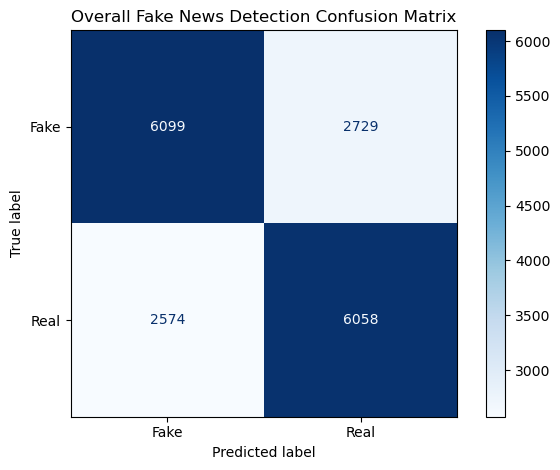

<Figure size 800x600 with 0 Axes>

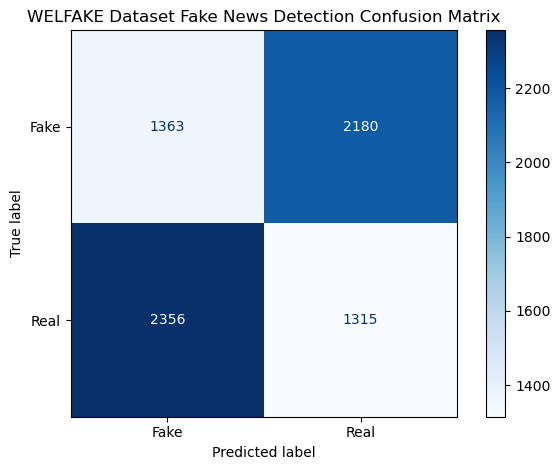

<Figure size 800x600 with 0 Axes>

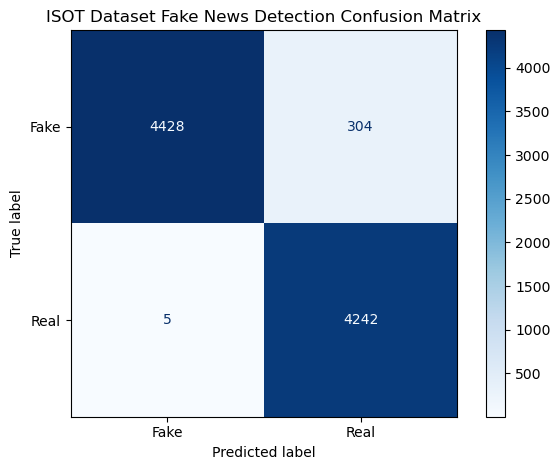

<Figure size 800x600 with 0 Axes>

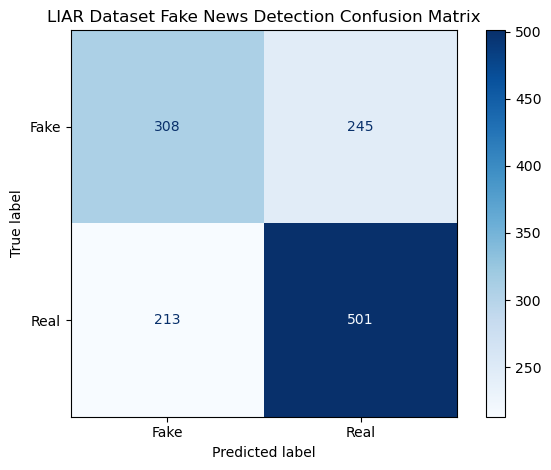


Model and tokenizer saved to balanced_fake_news_model_final


In [27]:
# run the pipeline 
# uncomment both lines of code below to run the full pipeline:

if __name__ == "__main__":
    run_balanced_fake_news_pipeline()

In [28]:
# for user: run this
# classify_text_input()